# Winter Project

In [1]:
import os
import kagglehub
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/home/aparr/anaconda3/envs/cais_tensor_2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-23 01:12:32.752607: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-23 01:12:32.811809: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734945152.848311  201067 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734945152.858198  201067 cuda_bla

In [2]:
seed = 42

In [3]:
# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /home/aparr/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [4]:
BATCH_SIZE = 32
from keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import Files
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip = True,
    rescale=1./255
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)


train_dataset = train_datagen.flow_from_directory(
    os.path.join(path, 'train'),
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=seed
)

test_dataset = validation_datagen.flow_from_directory(
    os.path.join(path, 'test'),
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
)

# train_dataset = image_dataset_from_directory(
#     os.path.join(path, 'train'),
#     label_mode = 'categorical',
#     color_mode = 'grayscale',
#     batch_size = BATCH_SIZE,
#     image_size = (48, 48),
#     shuffle = True,
#     seed = seed
# )

# train_iter = iter(train_dataset)

# test_dataset = image_dataset_from_directory(
#     os.path.join(path, 'test'),
#     label_mode = 'categorical',
#     color_mode = 'grayscale',
#     batch_size = BATCH_SIZE,
#     image_size = (48, 48),
#     shuffle = False,
# )
# test_iter = iter(test_dataset)
# test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
# test_labels = pd.from_dummies(pd.DataFrame(test_labels))[''].to_numpy() # Convert from one hot

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


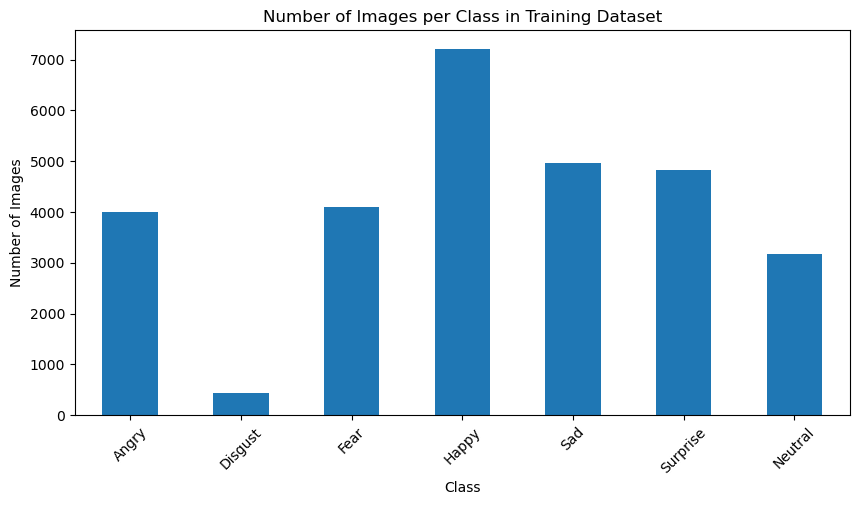

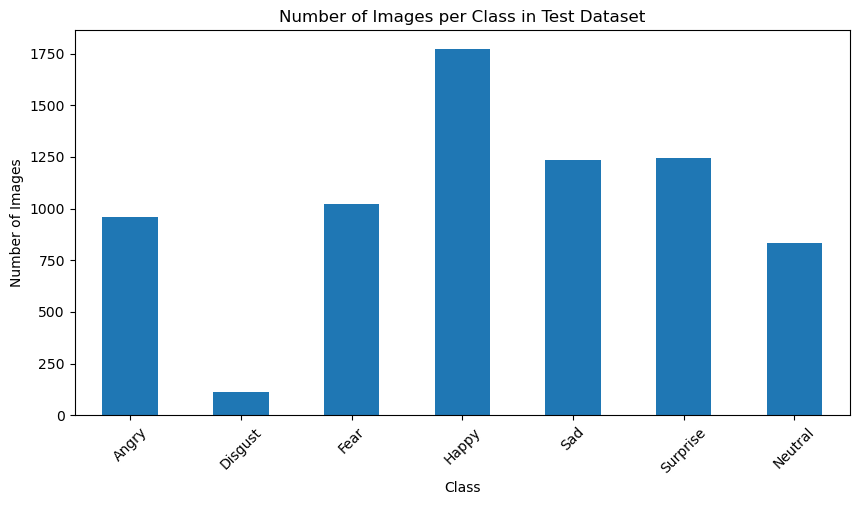

Label
0    3995
1     436
2    4097
3    7215
4    4965
5    4830
6    3171
Name: count, dtype: int64
Label
0     958
1     111
2    1024
3    1774
4    1233
5    1247
6     831
Name: count, dtype: int64


In [5]:
# Define class names
class_names = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

train_labels = np.array(train_dataset.labels)
test_labels = np.array(test_dataset.labels)

# Create dataframes for train and test labels
train_labels_df = pd.DataFrame(train_labels, columns=['Label'])
test_labels_df = pd.DataFrame(test_labels, columns=['Label'])

# Plot the number of images per class for the training dataset
plt.figure(figsize=(10, 5))
train_labels_df['Label'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Images per Class in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(ticks=np.arange(len(class_names)), labels=[class_names[i] for i in range(len(class_names))], rotation=45)
plt.show()

# Plot the number of images per class for the test dataset
plt.figure(figsize=(10, 5))
test_labels_df['Label'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Images per Class in Test Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(ticks=np.arange(len(class_names)), labels=[class_names[i] for i in range(len(class_names))], rotation=45)
plt.show()

print(train_labels_df['Label'].value_counts().sort_index())

print(test_labels_df['Label'].value_counts().sort_index())

In [44]:
FILTERS = 64
FILTER_SZ = 7
STRIDE = (1,1)
POOL_SZ = 2
from keras import models, layers, optimizers, callbacks

model = models.Sequential([
    layers.Input(shape=(48, 48, 1)),
    layers.Conv2D(FILTERS, FILTER_SZ, strides=STRIDE, padding='same', activation='relu'),
    layers.Conv2D(FILTERS, FILTER_SZ, strides=STRIDE, padding='same', activation='relu'),
    layers.AvgPool2D(POOL_SZ),
    layers.BatchNormalization(),
    layers.Conv2D(FILTERS, FILTER_SZ, strides=STRIDE, padding='same', activation='relu'),
    layers.Conv2D(FILTERS, FILTER_SZ, strides=STRIDE, padding='same', activation='relu'),
    layers.AvgPool2D(POOL_SZ),
    layers.BatchNormalization(),
    layers.Conv2D(FILTERS, FILTER_SZ, strides=STRIDE, padding='same', activation='relu'),
    layers.Conv2D(FILTERS, FILTER_SZ, strides=STRIDE, padding='same', activation='relu'),
    layers.AvgPool2D(POOL_SZ),
    layers.BatchNormalization(),
    layers.Conv2D(FILTERS, FILTER_SZ, strides=STRIDE, padding='same', activation='relu'),
    layers.Conv2D(FILTERS, FILTER_SZ, strides=STRIDE, padding='same', activation='relu'),
    layers.AvgPool2D(POOL_SZ),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(7, activation='softmax')
])

model.summary()

optimizer = optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'categorical_crossentropy'],
)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 48, 48, 64)     │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 48, 48, 64)     │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_30            │ (None, 24, 24, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 24, 24, 64)     │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 24, 24, 64)     │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_31            │ (None, 12, 12, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 12, 12, 64)     │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 12, 12, 64)     │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_32            │ (None, 6, 6, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 6, 6, 64)       │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 6, 6, 64)       │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_33            │ (None, 3, 3, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1024)           │       590,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │       262,65

 Total params: 3,316,807 (12.65 MB)

 Trainable params: 3,316,295 (12.65 MB)

 Non-trainable params: 512 (2.00 KB)

In [46]:
EPOCHS = 10
model_name = 'small_cnn2_hybrid_lowlr2'
checkpoint = callbacks.ModelCheckpoint('saved/'+model_name+'.keras', monitor='categorical_crossentropy', verbose=1, 
                             save_best_only=True, mode='max', save_freq='epoch')

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="categorical_crossentropy",
    factor=0.3,
    patience=2,
    verbose=1,
    mode="auto",
    min_delta=0.08,
    cooldown=0,
    min_lr=0.0,
)

history = model.fit( 
    train_dataset,
    epochs = EPOCHS,
    validation_data = (test_dataset),
    callbacks=[reduce_lr, checkpoint]
)
model.save('models/'+model_name+'_end.keras')
history_df=pd.DataFrame(history.history)
history_df.to_csv('models/'+model_name+'.csv')

Epoch 1/10
 95/898 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.2280 - categorical_crossentropy: 1.8803 - loss: 1.8803

2024-12-23 02:48:47.968558: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1684', 4 bytes spill stores, 4 bytes spill loads

2024-12-23 02:48:48.082331: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1684', 220 bytes spill stores, 220 bytes spill loads



898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2448 - categorical_crossentropy: 1.8221 - loss: 1.8221

2024-12-23 02:49:15.020681: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_249', 220 bytes spill stores, 220 bytes spill loads

2024-12-23 02:49:15.055858: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_249', 4 bytes spill stores, 4 bytes spill loads




Epoch 1: categorical_crossentropy improved from -inf to 1.80578, saving model to saved/small_cnn2_hybrid_lowlr2.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - accuracy: 0.2448 - categorical_crossentropy: 1.8221 - loss: 1.8221 - val_accuracy: 0.2272 - val_categorical_crossentropy: 1.8303 - val_loss: 1.8303 - learning_rate: 0.0010
Epoch 2/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2561 - categorical_crossentropy: 1.7883 - loss: 1.7883
Epoch 2: categorical_crossentropy did not improve from 1.80578
898/898 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.2561 - categorical_crossentropy: 1.7883 - loss: 1.7883 - val_accuracy: 0.2749 - val_categorical_crossentropy: 1.7736 - val_loss: 1.7736 - learning_rate: 0.0010
Epoch 3/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2829 - categorical_crossentropy: 1.7633 - loss: 1.7633
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 3: categorical_crossentropy did not improve from 1.80578


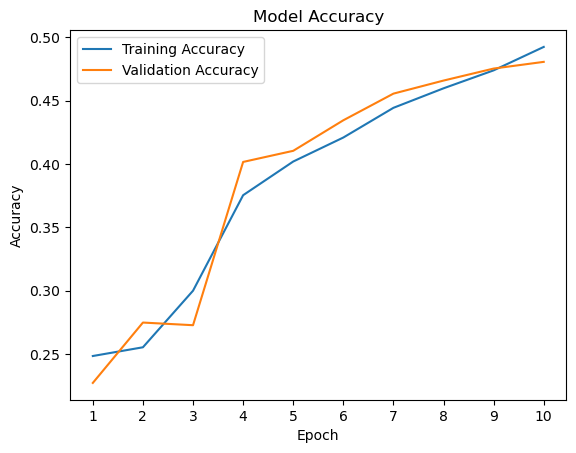

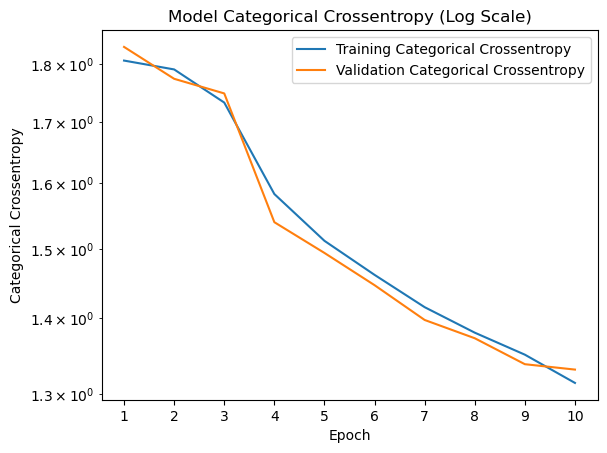

In [47]:
history_df[['accuracy', 'val_accuracy']].plot()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xticks(ticks=np.arange(EPOCHS), labels=np.arange(EPOCHS)+1)
plt.savefig(f'plots/{model_name}_accuracy.png')
plt.show()

history_df[['categorical_crossentropy', 'val_categorical_crossentropy']].plot()
plt.yscale('log')
plt.title('Model Categorical Crossentropy (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Categorical Crossentropy')
plt.legend(['Training Categorical Crossentropy', 'Validation Categorical Crossentropy'])
plt.xticks(ticks=np.arange(EPOCHS), labels=np.arange(EPOCHS)+1)
plt.savefig(f'plots/{model_name}_cross_entropy.png')

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.3899 - categorical_crossentropy: 1.5085 - loss: 1.5085
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
F1 Score: 0.44115645744541754
              precision    recall  f1-score   support

           0       0.39      0.27      0.32       958
           1       0.00      0.00      0.00       111
           2       0.29      0.14      0.19      1024
           3       0.56      0.90      0.69      1774
           4       0.45      0.42      0.44      1233
           5       0.32      0.25      0.28      1247
           6       0.61      0.74      0.67       831

    accuracy                           0.48      7178
   macro avg       0.37      0.39      0.37      7178
weighted avg       0.43      0.48      0.44      7178



/home/aparr/anaconda3/envs/cais_tensor_2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aparr/anaconda3/envs/cais_tensor_2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aparr/anaconda3/envs/cais_tensor_2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

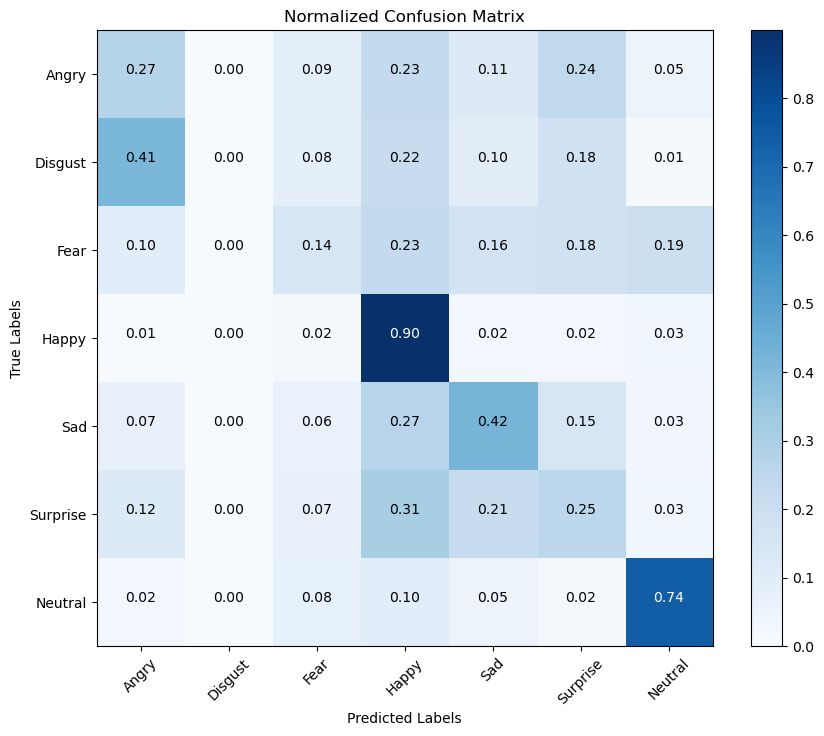

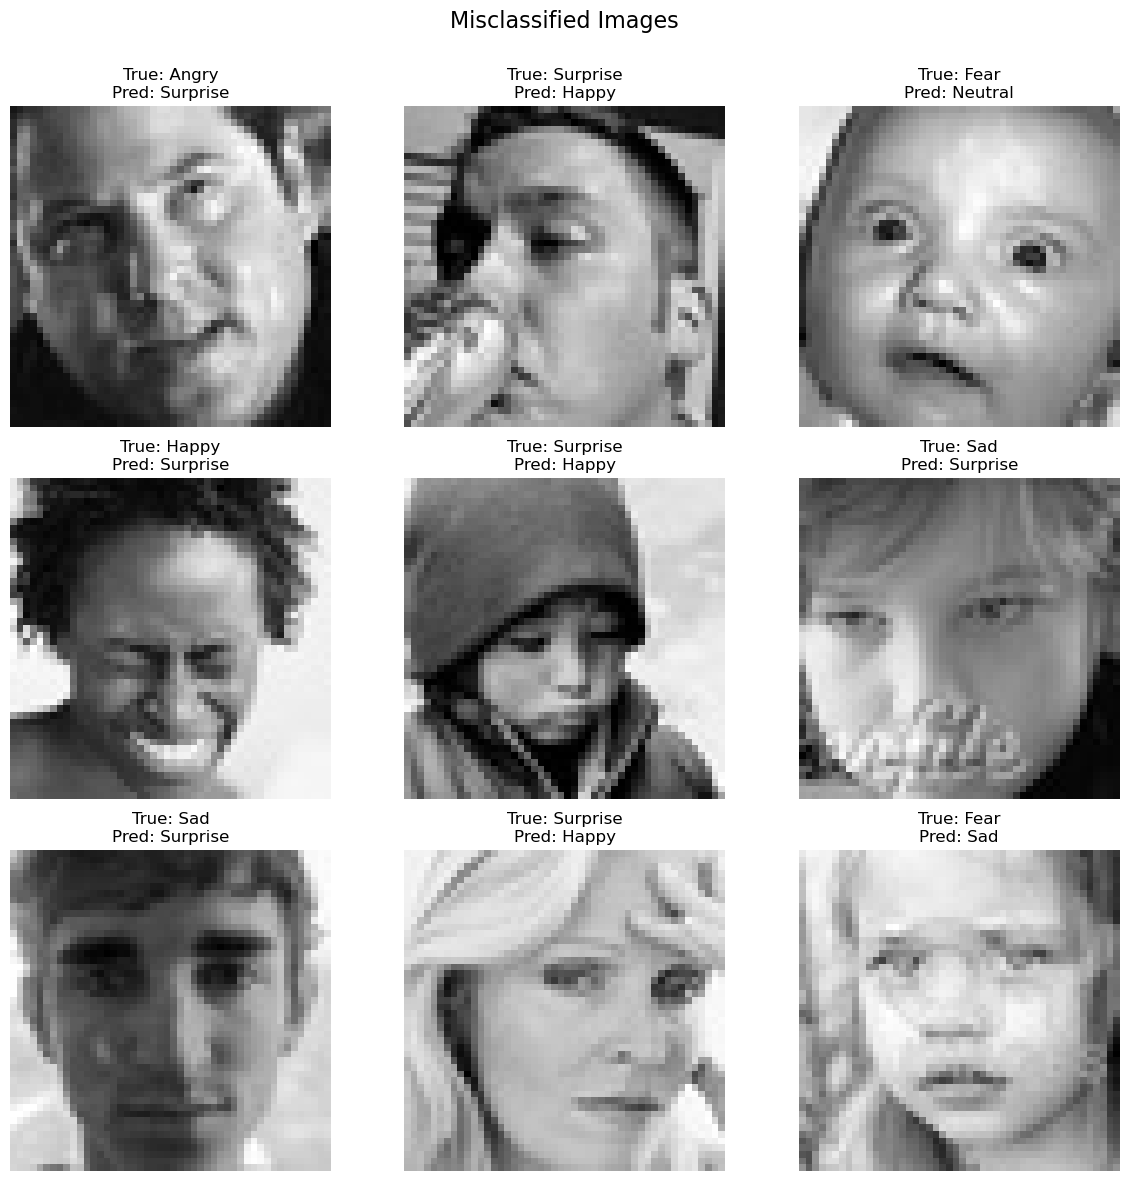

In [48]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# Evaluate the model on the test dataset
test_loss, test_accuracy, test_categorical_crossentropy = model.evaluate(test_dataset)

# Predict the labels for the test dataset
test_predictions = model.predict(test_dataset)
test_predictions = np.argmax(test_predictions, axis=1)

# Calculate the F1 score
f1 = f1_score(test_labels, test_predictions, average='weighted')
print(f"F1 Score: {f1}")
print(classification_report(test_labels, test_predictions))

# Create a confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Normalize the confusion matrix by row (i.e., by the number of samples in each true class)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap='Blues')
plt.title('Normalized Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, [class_names[i] for i in tick_marks], rotation=45)
plt.yticks(tick_marks, [class_names[i] for i in tick_marks])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add text annotations
thresh = conf_matrix_normalized.max() / 2.
for i, j in np.ndindex(conf_matrix_normalized.shape):
    plt.text(j, i, format(conf_matrix_normalized[i, j], '.2f'),
             horizontalalignment="center",
             color="white" if conf_matrix_normalized[i, j] > thresh else "black")

plt.savefig(f'plots/{model_name}_confusion.png')
plt.show()

# Extract test images from the test dataset
test_images = []
for i in range(len(test_dataset)):
    images, labels = test_dataset[i]
    test_images.extend(images)

test_images = np.array(test_images)

# Randomly sample 9 misclassified images
num_samples = 9
misclassified_indices = np.where(test_labels != test_predictions)[0]
np.random.seed(seed+4)
random_indices = np.random.choice(misclassified_indices, num_samples, replace=False)

# Plot the misclassified images in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Misclassified Images', fontsize=16)

for i, ax in enumerate(axes.flat):
    idx = random_indices[i]
    ax.imshow(test_images[idx].squeeze(), cmap='gray')
    true_label = class_names[test_labels[idx]]
    predicted_label = class_names[test_predictions[idx]]
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}")
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig(f'plots/{model_name}_misclassified.png')
plt.show()